In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/sample.csv


## Import libraries and dataset

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [3]:
train_df = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv')
train_df.head()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False


## Data Visualization

Text(0, 0.5, 'Frequency')

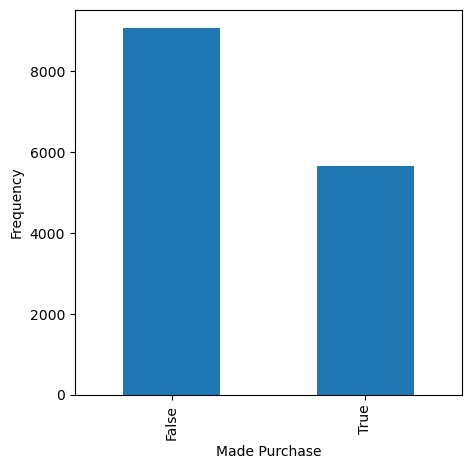

In [4]:
dv = train_df['Made_Purchase'].value_counts().plot(kind='bar', figsize=(5,5))
dv.set_xlabel("Made Purchase")
dv.set_ylabel("Frequency")

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

<AxesSubplot:>

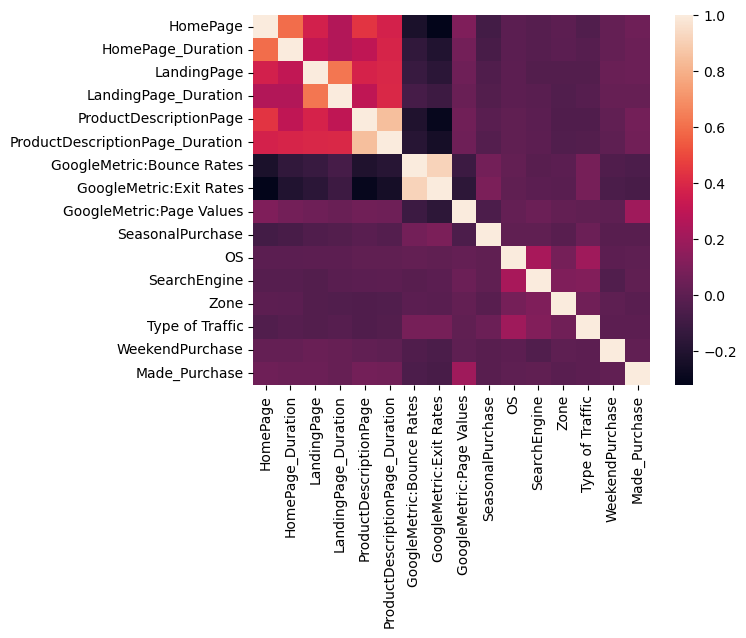

In [6]:
sns.heatmap(train_df.corr())

## Data Cleaning and Preprocessing

In [7]:
# drop columns with low correlation
train_df = train_df.drop(["GoogleMetric:Bounce Rates", "GoogleMetric:Exit Rates", "SeasonalPurchase", "WeekendPurchase"], axis=1)
train_df.head()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Page Values,Month_SeasonalPurchase,OS,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,Feb,4.0,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.0,Feb,3.0,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.0,Feb,3.0,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,Feb,2.0,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,Feb,1.0,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,False


In [8]:
# filter numerical and categorical variables
num_vars = ["HomePage", "HomePage_Duration", "LandingPage", "LandingPage_Duration", "ProductDescriptionPage", "ProductDescriptionPage_Duration", "GoogleMetric:Page Values"]
cat_vars = ["Month_SeasonalPurchase", "CustomerType", "Gender","Cookies Setting", "Education","Marital Status"]

In [9]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),("scaler", FunctionTransformer(np.log1p))]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars),
    ]
)

## Model Implementation

In [10]:
# split the dataframes into features and labels
X_train = train_df.drop(columns=['Made_Purchase'])
y_train = train_df['Made_Purchase']

### Support Vector Classification

In [11]:
X_train = preprocessor.fit_transform(X_train)
clf = SVC(C=1.0, kernel="rbf", gamma="auto")
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.6704908017106782

In [12]:
cvs = cross_val_score(clf, X_train, y_train)
cvs.mean()

0.5015401074101385

## Prediction and Submission

In [13]:
test_df = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv')
test_df.head()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,OS,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,...,1.0,1.0,1.0,1.0,Returning_Visitor,Not Specified,Deny,Not Specified,Single,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,...,2.0,2.0,1.0,2.0,Returning_Visitor,Not Specified,ALL,Graduate,Married,0.0
2,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,...,2.0,2.0,1.0,3.0,Returning_Visitor,Female,Required,Diploma,Other,0.0
3,0.0,0.0,0.0,0.0,2.0,37.000000,0.000000,0.100000,0.0,0.8,...,2.0,2.0,2.0,3.0,Returning_Visitor,Not Specified,Required,Graduate,Other,0.0
4,0.0,0.0,0.0,0.0,16.0,407.750000,0.018750,0.025833,0.0,0.4,...,1.0,1.0,4.0,3.0,Returning_Visitor,Female,Deny,Others,Other,0.0


In [14]:
y_pred = clf.predict(X_train)
f1_score(y_train, y_pred)

0.406891495601173

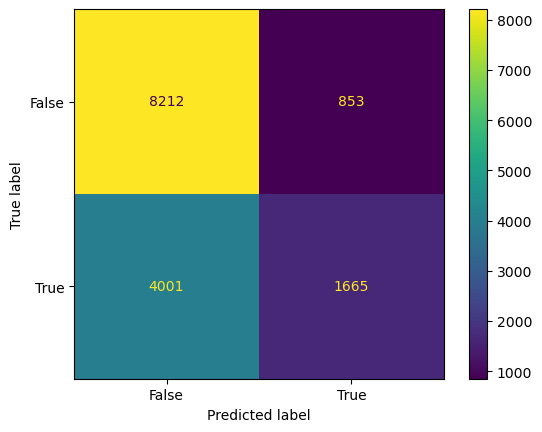

In [15]:
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [16]:
X_test = preprocessor.fit_transform(test_df)
prediction = clf.predict(X_test)

In [17]:
submission = pd.DataFrame(columns = ['id', 'Made_Purchase'])
submission['id'] = [i for i in range(len(prediction))]
submission['Made_Purchase'] = prediction
submission.head()

,id,Made_Purchase
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False


In [18]:
submission.to_csv('submission.csv', index=False)